In [1]:
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob as glb
%matplotlib inline

In [4]:
# Utils
def get_meta(l, d):
    """get meta data"""
    layer_re = re.compile('.+ Creating layer (.+)')
    iters_re = re.compile('Testing for\s+(\d+)\s+iterations.')
    th_re = re.compile('Number of OpenMP threads: (\d+)')
    batch_size_re = re.compile('batch_size: (\d+)')
    batch_size_re2 = re.compile('shape .*?dim: (\d+)',re.DOTALL)
    m = layer_re.findall(l)
    if(m is not []): layers = m

    m = iters_re.search(l)
    if(m is not None): d['iterations'] = int(m.group(1))    

    m = th_re.search(l)
    if(m is not None): d['threads'] = int(m.group(1))    

    m = batch_size_re.search(l)
    if(m is not None):
        d['batch size'] = int(m.group(1))
    else:
        m = batch_size_re2.search(l)
        if(m is not None):
            d['batch size'] = int(m.group(1))
    
    d['layers'] = set(layers)
    return d


def get_data(l, entry):
    """get the time of each layer and the total"""
    #total timing
    fd_re = re.compile('.+Average Forward pass:\s+(.+)\s+ms.')
    bd_re = re.compile('.+Average Backward pass:\s+(.+)\s+ms.')
    total_re = re.compile('.+Total Time:\s+(.+)\s+ms.')
    m = fd_re.search(l)
    if(m is not None): entry['avg forward'] = float(m.groups(1)[0])/1e3
    m = bd_re.search(l)
    if(m is not None): entry['avg backward'] = float(m.groups(1)[0])/1e3
    m = total_re.search(l)
    if(m is not None):
        entry['total time'] = float(m.groups(1)[0])/1e3
        entry['time per iteration'] = entry['total time']/entry['iterations']
    # layers timing
    ltime_re = re.compile('.+\s+(\w+)\s+(forward|backward):\s*(.+)\s+ms.')
    m = ltime_re.findall(l)
    layers_data = {lname+' '+direction: float(val)/1e3 for lname,direction,val in m}
    entry.update(layers_data)
    # layers memory footprint
    for layer in entry['layers']:
        lmem_re = re.compile('Creating layer\s+('+layer+').*Memory required for data:\s+(\d+)',re.DOTALL)
        m = lmem_re.search(l)
        if(m is not None): entry[m.groups(0)[0]+' memory'] = int(m.groups(0)[1])

def get_df(flist):
    """Parse the files in a dataframe"""
    data = []
    for f in flist:
        with open(f, 'r') as fp:
            entry = dict()
            txt = fp.read() #.split('\n')
            get_meta(txt, entry)
            get_data(txt, entry)
            entry['file name'] =f
            data.append(pd.DataFrame([entry]))
    df = pd.concat(data)
    df.reset_index(inplace=True)
    return df

def normalize_batches(df):
    """Normalize the time by the batch size"""
    df_norm = df.copy()
    time_fields = [s for s in df.columns.values if('ward' in s or 'time' in s)]
    for f in time_fields:
        df_norm.loc[:, f] = df.loc[:, f]/df.loc[:, 'batch size']
    return df_norm

def normalize_time(df):
    """Normalize the time by the total time"""
    df_norm = df.copy()
    time_fields = [s for s in df.columns.values if('ward' in s  or 'time per iteration' in s)]
    for f in time_fields:
        df_norm.loc[:, f] = 100.0*df.loc[:, f]/df.loc[:, 'time per iteration']
    del df_norm['total time']
    return df_norm

def group_small_entries(df, threas):
    """Sum insignificant entries in one column that fall
    below the 'threas' percentile of the total time"""
    df_filt = df.copy()
    df_filt['others'] = 0.0
    df_norm_time = normalize_time(df)
    time_fields = [s for s in df.columns.values if('ward' in s)]
    for f in time_fields:
        if(not all(df_norm_time[f].apply(lambda x: x > threas))):
            df_filt['others'] = df_filt['others'] + df_filt[f]
            del df_filt[f]
    return df_filt

def plot_batch_scaling(df, threas):
    """Plot batch scaling from a data frame table"""
    df.drop_duplicates('batch size',inplace=True)
    df_norm_batch = normalize_batches(df)
    df_filt = group_small_entries(df_norm_batch, threas)

    layers_cols = [s for s in df_filt.columns.values if('ward' in s and not 'avg' in s)]
    layers_cols = layers_cols + ['others']
    df_filt.index = df_filt['batch size']
    plt_data = pd.DataFrame(df_filt[layers_cols],index=df_filt['batch size'], columns=layers_cols)

    plt_data= plt_data.sort_index()

    ax = plt_data.plot(kind='bar', stacked=True)
    ax.set_ylabel('Stacked time per batch size per iter. (seconds)')
    ax.set_xlabel('Batch size')
    return ax

def plot_thread_scaling(df, threas):
    """Plot thread scaling from a data frame table"""
    df_filt = group_small_entries(df, threas)

    layers_cols = [s for s in df_filt.columns.values if('ward' in s and not 'avg' in s)]
    layers_cols = layers_cols + ['others']
    df_filt.index = df_filt['threads']
    plt_data = pd.DataFrame(df_filt[layers_cols],index=df_filt['threads'], columns=layers_cols)

    plt_data= plt_data.sort_index()

    ax = plt_data.plot(marker='o')
    ax.set_xscale('log',basex=2)
    ax.set_yscale('log')
    ax.set_ylabel('Time per iter. (seconds)')
    ax.set_xlabel('Threads #')
    return ax

def plot_all_batch_scaling(f_wildcard, threshold=1.0, res_path=''):
    """filter and split the files from the provided wildcard
    and plot the batch scaling figures"""
    flist = glb(f_wildcard)
    axis_l = dict()
    for arch in ['hsw', 'knl']:
        axis_l[arch] = dict()
        flist_arch = [f for f in flist if arch in f]

        df = get_df(flist_arch)
        grps = df.groupby(['threads']).groups
        plt_grp = [(gk,gv) for gk, gv in grps.iteritems() if len(gv) >1]

        batch_plts = dict()
        for th, entries in plt_grp:
            batch_plts[th] = df.loc[entries,:]
            axis_l[arch][th] = plot_batch_scaling(batch_plts[th], threshold)
            axis_l[arch][th].set_title(arch+' batch scaling with '+str(th)+' threads')
            axis_l[arch][th].set_ylim(ymin=0)
            axis_l[arch][th].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.savefig(os.path.join(res_path, arch+'_batch scaling_'+str(th)+'th.jpg'), format='jpg',bbox_inches='tight')
    return axis_l

def plot_all_thread_scaling(f_wildcard, threshold=1.0, res_path=''):
    """filter and split the files from the provided wildcard
    and plot the thread scaling figures"""
    flist = glb(f_wildcard)
    axis_l = dict()
    for arch in ['hsw', 'knl']:
        axis_l[arch] = dict()
        flist_arch = [f for f in flist if arch in f]

        df = get_df(flist_arch)
        grps = df.groupby(['batch size']).groups
        plt_grp = [(gk,gv) for gk, gv in grps.iteritems() if len(gv) >1]

        th_plts = dict()
        for batch_size, entries in plt_grp:
            th_plts[batch_size] = df.loc[entries,:]
            axis_l[arch][batch_size] = plot_thread_scaling(th_plts[batch_size], threshold)
            axis_l[arch][batch_size].set_title(arch+' thread scaling with '+str(batch_size)+' batch size')
            axis_l[arch][batch_size].set_ylim(ymin=0)
            axis_l[arch][batch_size].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.savefig(os.path.join(res_path, arch+'_thread_scaling_'+str(batch_size)+'_batch_size.jpg'), format='jpg',bbox_inches='tight')
    return axis_l

{'hsw': {16: <matplotlib.axes._subplots.AxesSubplot at 0x10a2c8690>},
 'knl': {68: <matplotlib.axes._subplots.AxesSubplot at 0x10b1b8ad0>}}

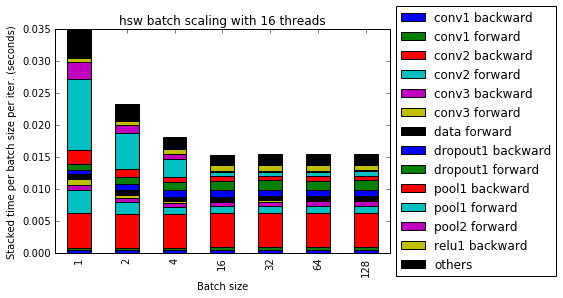

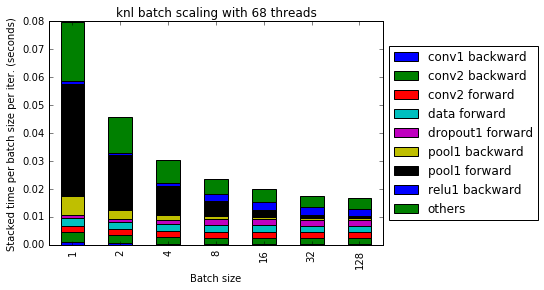

In [5]:
# optimized results
files_loc = '/Users/tmalas/Desktop/caffe/atlas_caffe_opt/*/*.out'
%mkdir -p /Users/tmalas/Desktop/dnn_opt
res_path='/Users/tmalas/Desktop/dnn_opt'
plot_all_batch_scaling(files_loc, res_path=res_path)
#plot_all_thread_scaling(files_loc, res_path=res_path)

{'hsw': {1: <matplotlib.axes._subplots.AxesSubplot at 0x10b7c2b90>},
 'knl': {1: <matplotlib.axes._subplots.AxesSubplot at 0x10c859650>}}

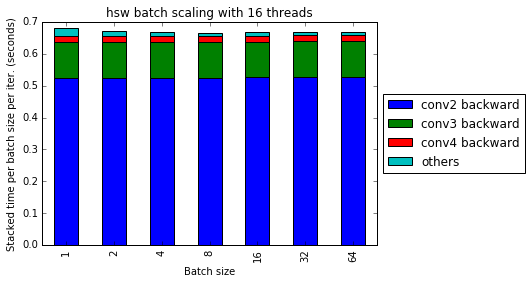

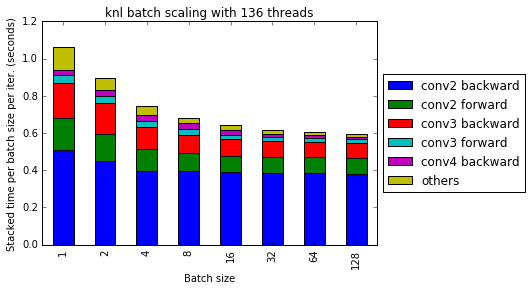

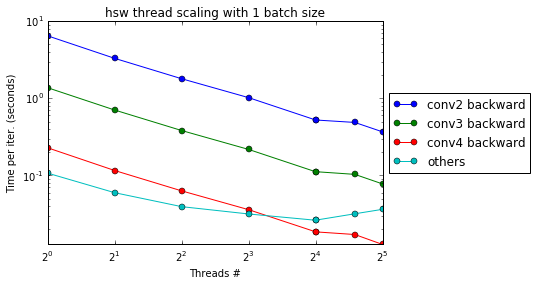

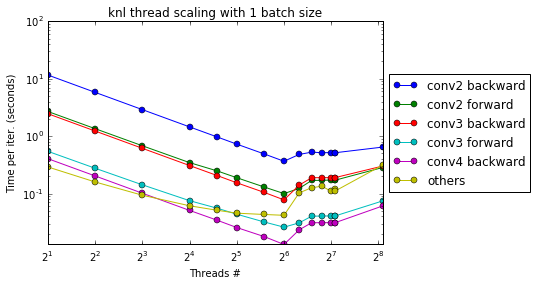

In [6]:
# first results (unoptimized)
files_loc = '/Users/tmalas/Desktop/caffe/first_atlas_caffe_results/*/*.out'
%mkdir -p /Users/tmalas/Desktop/dnn_first
res_path='/Users/tmalas/Desktop/dnn_first'
plot_all_batch_scaling(files_loc, res_path=res_path)
plot_all_thread_scaling(files_loc, res_path=res_path)